In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import acquire
import summarize
import prepare

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# ACQUIRE

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.logerror.mean()

0.01659829124491966

In [4]:
df[(df.bathroomcnt > df.bedroomcnt)].logerror.mean()

0.01944965567235996

In [5]:
df[(df.bathroomcnt < df.bedroomcnt)].logerror.mean()

0.017646440585589045

In [6]:
df[(df.bathroomcnt == df.bedroomcnt)].logerror.mean()

0.013109882542635579

#### Keep the Master Latitude Longitude DataFrame

In [7]:
lat_long = df[['latitude','longitude']]

In [8]:
len(lat_long)

73424

# Prepare

### Get rid of nulls. Heating will get imputed. Null rows will be dropped.

In [9]:
#The columns that have to do with the building themselves. No location data except for lat-long.
house_vars = ['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','heatingorsystemtypeid','lotsizesquarefeet','yearbuilt','structuretaxvaluedollarcnt', 'taxvaluedollarcnt','latitude','longitude','logerror']

In [10]:
house_vars

['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'heatingorsystemtypeid',
 'lotsizesquarefeet',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'latitude',
 'longitude',
 'logerror']

In [11]:
structures_df = df[house_vars]

In [12]:
structures_df.heatingorsystemtypeid.fillna(2, inplace=True)

In [13]:
structures_df.dropna(inplace=True)

In [14]:
summarize.nulls_by_col(structures_df)

,num_rows_missing,pct_rows_missing
bathroomcnt,0,0.0
bedroomcnt,0,0.0
calculatedfinishedsquarefeet,0,0.0
heatingorsystemtypeid,0,0.0
lotsizesquarefeet,0,0.0
yearbuilt,0,0.0
structuretaxvaluedollarcnt,0,0.0
taxvaluedollarcnt,0,0.0
latitude,0,0.0
longitude,0,0.0


### Split into the train and test sets

In [15]:
train, test = train_test_split(structures_df, train_size = .8, random_state = 123)

In [16]:
train.drop(['latitude','longitude'],axis=1,inplace=True)

test.drop(['latitude','longitude'],axis=1,inplace=True)

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52212 entries, 72193 to 59343
Data columns (total 9 columns):
bathroomcnt                     52212 non-null float64
bedroomcnt                      52212 non-null float64
calculatedfinishedsquarefeet    52212 non-null float64
heatingorsystemtypeid           52212 non-null float64
lotsizesquarefeet               52212 non-null float64
yearbuilt                       52212 non-null float64
structuretaxvaluedollarcnt      52212 non-null float64
taxvaluedollarcnt               52212 non-null float64
logerror                        52212 non-null float64
dtypes: float64(9)
memory usage: 4.0 MB


### USE STANDARD SCALING

In [18]:
standard_train, standard_test, standard_object = prepare.standardize_train_test(train, test)

### Drop the upper outliers

In [19]:
no_outliers = prepare.remove_upper_outliers(standard_train.calculatedfinishedsquarefeet, train)
no_outliers = prepare.remove_upper_outliers(standard_train.lotsizesquarefeet, train)

In [21]:
no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43605 entries, 72193 to 59343
Data columns (total 9 columns):
bathroomcnt                     43605 non-null float64
bedroomcnt                      43605 non-null float64
calculatedfinishedsquarefeet    43605 non-null float64
heatingorsystemtypeid           43605 non-null float64
lotsizesquarefeet               43605 non-null float64
yearbuilt                       43605 non-null float64
structuretaxvaluedollarcnt      43605 non-null float64
taxvaluedollarcnt               43605 non-null float64
logerror                        43605 non-null float64
dtypes: float64(9)
memory usage: 3.3 MB


In [22]:
kmean = KMeans(n_clusters=3)

In [23]:
kmean.fit(no_outliers)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [24]:
predictions3 = kmean.labels_

no_outliers['cluster_labels3'] = predictions3

In [25]:
np.unique(predictions3, return_counts=True)

(array([0, 1, 2], dtype=int32), array([35145,   577,  7883]))

In [27]:
no_outliers.groupby('cluster_labels3').mean()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,heatingorsystemtypeid,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,logerror
cluster_labels3,,,,,,,,,
0,2.052767,3.097027,1592.180936,3.379940,7158.042225,1962.474434,1.253331e+05,3.101240e+05,0.016808
1,4.373484,4.138648,4106.178510,2.291161,10525.384749,1976.850953,1.036988e+06,3.493941e+06,0.020724
2,3.046239,3.677407,2657.617151,2.520741,8695.313713,1974.532792,3.632909e+05,1.032714e+06,0.018309


In [ ]:
## THE 2nd Cluster does the best. Very low log error.

In [29]:
no_outliers[['latitude','longitude']] = lat_long

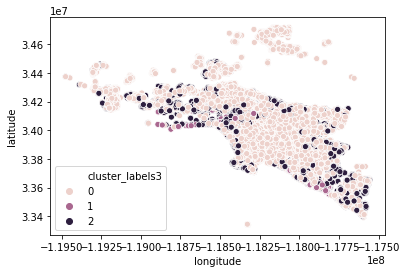

In [30]:
sns.scatterplot(data=no_outliers, x='longitude', y='latitude', hue='cluster_labels3')

In [ ]:
sns.scatterplot(data=df, x='longitude', y='latitude')

In [ ]:
import cluster

In [ ]:
cluster.show_clusters_on_map()